# **BBM 409: Machine Learning Laboratory 👨🏻‍🔬**
### **Project Assignment 2**  

### **Group 13**

- **Mert Çetin** - 2220356148  
- **Mehmet Oğuz Kocadere** - 2210356021  

### **Environment**  
- **Python Version**: 3.9.6  

In [2]:
import pandas as pd
import numpy as np

# file path
file_path = "financial_risk_assessment.csv"

# read csv file
df = pd.read_csv(file_path)

df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


# **Part 1: Implementing Decision Tree 🌳**

In [3]:
# Display general information about the dataset
print("🔎 Dataset Information:")
df.info()

# Show number of missing values in each column
print("\n❗ Missing Values per Column:")
print(df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include="object").columns
print("\n🧩 Categorical Columns:")
print(categorical_cols)

# Show missing values only in categorical columnso
print("\n📋 Missing Values in Categorical Columns:")
print(df[categorical_cols].isnull().sum())

🔎 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 no

### **🤔 Handling Missing Values (Median Imputation)**

In this dataset, some numerical columns like *Income*, *Credit Score*, *Loan Amount*, *Assets Value*, *Number of Dependents*, and *Previous Defaults* had missing values (2,250 missing entries in each column, which is 15% of the data). In this step, we filled the missing values in *Income*, *Credit Score*, *Loan Amount*, and *Assets Value* using the **median** of each column.

We chose the median instead of the average (mean) because the median is less affected by very high or low values (outliers), which are common in financial data. This method helps us keep the data more stable and prevents our decision tree model from learning wrong patterns due to missing values.

We also checked the categorical columns for missing values (such as *Gender*, *Education Level*, *Marital Status*, *Loan Purpose*, *Employment Status*, etc.), and confirmed that there were **no missing values** in these columns. Therefore, no additional imputation was needed for categorical data.

**Note:** For *Number of Dependents* and *Previous Defaults*, we will analyze their frequency distributions in the next step to determine the best imputation strategy, as these columns contain discrete values (0, 1, 2, 3 or 4) and require a more careful approach to preserve their distribution.

In [4]:
# List of numerical columns with missing values
numeric_missing_cols = [
    "Income", "Credit Score", "Loan Amount",
    "Assets Value", "Number of Dependents",
    "Previous Defaults"
]

# Fill missing values in 'Income' based on 'Education Level' and 'Employment Status'
for edu in df['Education Level'].unique():
    for emp in df['Employment Status'].unique():
        mask = (df['Education Level'] == edu) & (df['Employment Status'] == emp)
        median_income = df.loc[mask, 'Income'].median()
        df.loc[mask & df['Income'].isna(), 'Income'] = median_income

# Fill missing 'Credit Score' based on 'Payment History'
for payment in df['Payment History'].unique():
    mask = df['Payment History'] == payment
    median_score = df.loc[mask, 'Credit Score'].median()
    df.loc[mask & df['Credit Score'].isna(), 'Credit Score'] = median_score

# Fill any remaining missing values with global median (avoiding chained assignment)
df['Income'] = df['Income'].fillna(df['Income'].median())
df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())
df['Loan Amount'] = df['Loan Amount'].fillna(df['Loan Amount'].median())
df['Assets Value'] = df['Assets Value'].fillna(df['Assets Value'].median())

# Verify missing values are filled
print("\nMissing values after median imputation (excluding Number of Dependents and Previous Defaults):")
print(df[["Income", "Credit Score", "Loan Amount", "Assets Value"]].isnull().sum())


Missing values after median imputation (excluding Number of Dependents and Previous Defaults):
Income          0
Credit Score    0
Loan Amount     0
Assets Value    0
dtype: int64


### **🎲 Imputation for Number of Dependents and Previous Defaults (Random Imputation)**

We applied **random imputation** to handle missing values in *Number of Dependents* and *Previous Defaults*.

For each column, we calculated the probability distribution of the existing values (excluding NaN) and used these probabilities to randomly assign values to the 2,250 missing entries. This approach ensures that the original distribution is preserved, maintaining balanced frequencies and proportions after imputation. Random imputation keeps the data’s natural structure intact, potentially enhancing the informativeness of these features in the model.

In [5]:
# Random imputation for "Number of Dependents" and "Previous Defaults"
def random_impute(df, target_col):
    # Calculate the frequency of each category in the target column
    probs = df[target_col].value_counts(normalize=True, dropna=True)
    # Calculate the number of missing values in the target column
    n_missing = df[target_col].isnull().sum()
    # Generate random values based on the calculated probabilities
    imputed_values = np.random.choice(probs.index, size=n_missing, p=probs.values)
    # Fill the missing values in the target column with the generated random values
    df.loc[df[target_col].isnull(), target_col] = imputed_values
    return df

# Apply random imputation for "Number of Dependents" and "Previous Defaults"
df = random_impute(df, "Number of Dependents")
df = random_impute(df, "Previous Defaults")

# Verify that missing values in "Number of Dependents" and "Previous  Defaults" have been filled
print("\nMissing values after random imputation:")
print(df[["Number of Dependents", "Previous Defaults"]].isnull().sum())

# Display the updated frequency and probability distributions
print("\nNumber of Dependents - New Frequencies:")
print(df["Number of Dependents"].value_counts())
print("\nNumber of Dependents - New Probabilities:")
print(df["Number of Dependents"].value_counts(normalize=True))

print("\nPrevious Defaults - New Frequencies:")
print(df["Previous Defaults"].value_counts())
print("\nPrevious Defaults - New Probabilities:")
print(df["Previous Defaults"].value_counts(normalize=True))


Missing values after random imputation:
Number of Dependents    0
Previous Defaults       0
dtype: int64

Number of Dependents - New Frequencies:
Number of Dependents
4.0    3064
3.0    3048
1.0    3033
2.0    2962
0.0    2893
Name: count, dtype: int64

Number of Dependents - New Probabilities:
Number of Dependents
4.0    0.204267
3.0    0.203200
1.0    0.202200
2.0    0.197467
0.0    0.192867
Name: proportion, dtype: float64

Previous Defaults - New Frequencies:
Previous Defaults
2.0    3040
1.0    3033
4.0    3005
0.0    3005
3.0    2917
Name: count, dtype: int64

Previous Defaults - New Probabilities:
Previous Defaults
2.0    0.202667
1.0    0.202200
4.0    0.200333
0.0    0.200333
3.0    0.194467
Name: proportion, dtype: float64


### **🔠 Encoding Categorical Features**

To prepare the dataset for the ID3 decision tree algorithm, we manually encoded the categorical features into numerical values. This is important because the algorithm requires numerical comparisons to calculate entropy and information gain. Below, each category in features like *Gender*, *Education Level* and *Marital Status* are mapped to an integer by hand.

Gender: [0 1 2]
Education Level: [3 1 2 0]
Marital Status: [2 3 0 1]
Loan Purpose: [3 1 0 2]
Employment Status: [0 1 2]
Payment History: [0 1 3 2]
Risk Rating: [0 1 2]


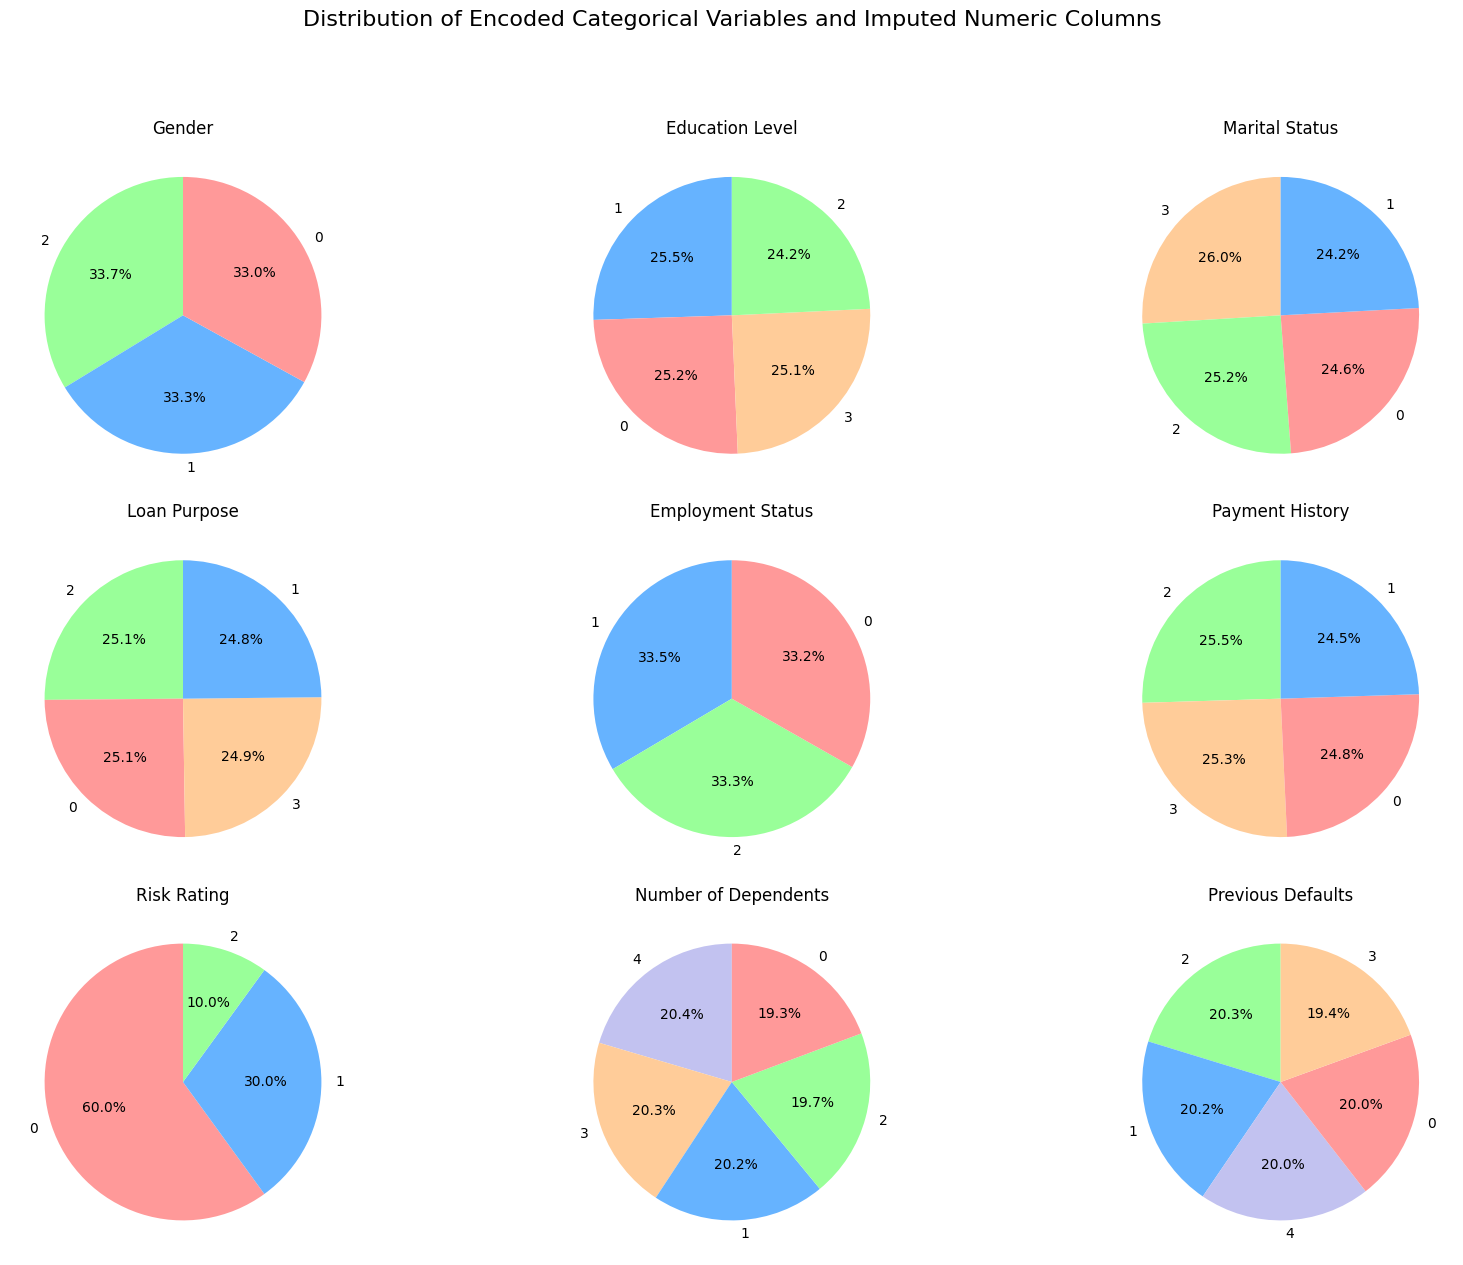

In [6]:
import matplotlib.pyplot as plt

# Encoding mappings for categorical variables
encoding_maps = {
    "Gender": {"Male": 0, "Female": 1, "Non-binary": 2},
    "Education Level": {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3},
    "Marital Status": {"Single": 0, "Married": 1, "Divorced": 2, "Widowed": 3},
    "Loan Purpose": {"Home": 0, "Auto": 1, "Personal": 2, "Business": 3},
    "Employment Status": {"Unemployed": 0, "Employed": 1, "Self-employed": 2},
    "Payment History": {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3},
    "Risk Rating": {"Low": 0, "Medium": 1, "High": 2}  # Target variable
}

# Apply encoding
for col, mapping in encoding_maps.items():
    df[col] = df[col].map(mapping)

# Check unique values after encoding
print("Gender:", df["Gender"].unique())
print("Education Level:", df["Education Level"].unique())
print("Marital Status:", df["Marital Status"].unique())
print("Loan Purpose:", df["Loan Purpose"].unique())
print("Employment Status:", df["Employment Status"].unique())
print("Payment History:", df["Payment History"].unique())
print("Risk Rating:", df["Risk Rating"].unique())

# Prepare for pie charts
columns = list(encoding_maps.keys()) + ["Number of Dependents", "Previous Defaults"]
n_cols = len(columns)  # 9 sütun var

# Create a figure with subplots (3 rows, 3 columns to fit 9 pie charts)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Add a title to the entire figure
fig.suptitle("Distribution of Encoded Categorical Variables and Imputed Numeric Columns", fontsize=16, y=1.05)

# Define a color mapping for each value (0, 1, 2, 3, 4)
color_map = {
    0: '#ff9999',  
    1: '#66b3ff',  
    2: '#99ff99',  
    3: '#ffcc99',  
    4: '#c2c2f0'   
}

# Define a shared label mapping
shared_labels = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4"}

# Plot a pie chart for each column
for i, col in enumerate(columns):
    # Count the frequency of each encoded or numeric value in the column
    value_counts = df[col].value_counts()
    
    # Prepare data for the pie chart
    labels = [shared_labels[val] for val in value_counts.index if val in shared_labels]
    sizes = value_counts.values
    # Renkleri değerlere göre eşleştir
    colors = [color_map[val] for val in value_counts.index if val in color_map]
    
    # Plot the pie chart
    axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### **📉 Why Class Balance Matters**

In the original dataset, the class distribution is imbalanced:  
Most samples belong to the **"Low" risk** class, while **"Medium"** and especially **"High"** risk classes have much fewer examples.

Because of this imbalance, a decision tree trained directly on this data would mostly learn how to predict "Low", and ignore the other two classes.  
This leads to high accuracy but poor performance for the minority classes.

In [7]:
# Original class distribution
original_ratios = df["Risk Rating"].value_counts(normalize=True)
print("Original Class Ratios (Low=0, Medium=1, High=2):")
print(original_ratios)

Original Class Ratios (Low=0, Medium=1, High=2):
Risk Rating
0    0.6
1    0.3
2    0.1
Name: proportion, dtype: float64


### **🔁 Fixing Class Imbalance with Manual Oversampling**

After observing the class imbalance (60% Low, 30% Medium, 10% High),  
we manually apply **oversampling** to improve learning for minority classes.

Because using automated tools like `SMOTE` is **not allowed**, we generate new samples for Medium and High classes by:
- Slightly modifying numeric features with noise (jitter)
- Shuffling categorical values for variety

In [8]:
# Separate each class
df_0 = df[df["Risk Rating"] == 0]  # Majority: Low
df_1 = df[df["Risk Rating"] == 1]  # Medium
df_2 = df[df["Risk Rating"] == 2]  # High

# Columns to modify
numeric_cols = ["Age", "Income", "Credit Score", "Loan Amount", "Assets Value", "Debt-to-Income Ratio", "Years at Current Job"]
categorical_cols = ["Marital Status", "Gender", "Job Title", "Loan Purpose", "Education Level"]

# Manual augmentation function
def augment(df, n_times, jitter_std=0.05):
    augmented = []
    for _ in range(n_times):
        df_copy = df.copy()

        for col in numeric_cols:
            if col in df_copy.columns:
                std = df_copy[col].std()
                noise = np.random.normal(0, jitter_std * std, size=len(df_copy))
                df_copy[col] += noise

        for col in categorical_cols:
            if col in df_copy.columns:
                df_copy[col] = np.random.permutation(df_copy[col].values)

        augmented.append(df_copy)
    return pd.concat(augmented, ignore_index=True)

# Controlled oversampling: small boost
df_1_aug = augment(df_1, n_times=1)  # Medium
df_2_aug = augment(df_2, n_times=5)  # High

# Create the balanced dataset
df_balanced = pd.concat([df_0, df_1, df_2, df_1_aug, df_2_aug], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print("✅ Balanced dataset shape:", df_balanced.shape)
print("✅ New class ratios:")
print(df_balanced["Risk Rating"].value_counts(normalize=True))

✅ Balanced dataset shape: (27000, 20)
✅ New class ratios:
Risk Rating
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


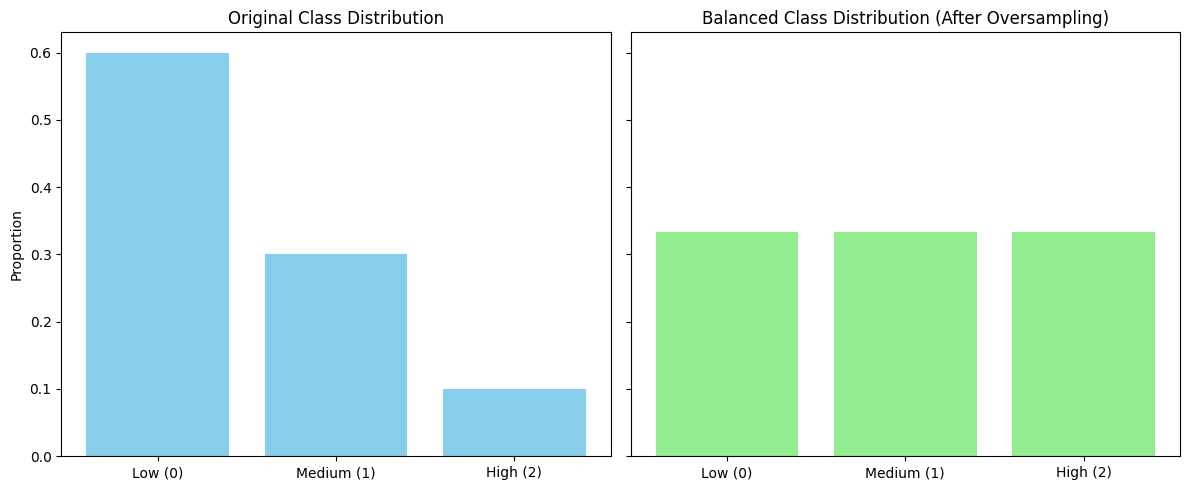

In [9]:
# Calculate before and after class distributions
before_ratios = df["Risk Rating"].value_counts(normalize=True).sort_index()
after_ratios = df_balanced["Risk Rating"].value_counts(normalize=True).sort_index()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].bar(["Low (0)", "Medium (1)", "High (2)"], before_ratios, color='skyblue')
axs[0].set_title("Original Class Distribution")
axs[0].set_ylabel("Proportion")

axs[1].bar(["Low (0)", "Medium (1)", "High (2)"], after_ratios, color='lightgreen')
axs[1].set_title("Balanced Class Distribution (After Oversampling)")

plt.tight_layout()
plt.show()

### **🧹 Cleaning Up Columns Before Splitting**

Before splitting the dataset, we removed several columns from `X` to simplify the decision tree and reduce noise:

- **`Risk Rating`**: This is the target variable. We stored it in `y` and removed it from `X`.
- **`City`, `State`, `Country`**: These location-based features contain too many unique values, leading to overly complex and less generalizable splits. They were dropped due to their low relevance to financial risk.

This pre-pruning step helps the decision tree model focus on more informative and manageable features.

In [10]:
from sklearn.model_selection import train_test_split

df = df_balanced.copy() # use the balanced dataset

# X = df.drop(columns=["Risk Rating", "City", "State", "Country"])  # Drop the irrelevant columns

# Additional prepruning
X = df.drop(columns=["Risk Rating", "City", "State", "Country", "Marital Status"])  # Drop the irrelevant columns

y = df["Risk Rating"]  # Target variable

# Stratified split 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Reset index for all sets
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Size check
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

# Target variable distribution check
print("Unique values in y_train:", np.unique(y_train))

Train set size: (18900, 15)
Validation set size: (4050, 15)
Test set size: (4050, 15)
Unique values in y_train: [0 1 2]


### **⚖️ Adjusting Class Weights for Imbalance**

After oversampling, the class distribution became fully balanced:
- 33% Low  
- 33% Medium  
- 33% High

To guide the decision tree during training, we calculated **class weights inversely proportional to these new ratios**.  
This ensures that the model continues to treat all classes equally when determining splits, even though the data is now balanced.

We did **not normalize** the weights to maintain the same scale across all classes.  
The final weights were:

- Class 0 (Low): **3.0**  
- Class 1 (Medium): **3.0**  
- Class 2 (High): **3.0**

These weights reflect the perfectly **balanced training distribution** and ensure consistent emphasis across all classes during learning.

In [11]:
# Calculate class ratios
class_counts = np.bincount(y_train)
class_ratios = class_counts / len(y_train)
print("Class Ratios (Low, Medium, High):", class_ratios)

# More aggressive class weighting (no normalization)
inverse_ratios = 1 / class_ratios

# Normalize the inverse ratios to sum to 1
class_weights_dict = {i: float(inverse_ratios[i]) for i in range(len(inverse_ratios))}

# Print the adjusted class weights
print("Adjusted Class Weights (No Normalization):", class_weights_dict)

Class Ratios (Low, Medium, High): [0.33333333 0.33333333 0.33333333]
Adjusted Class Weights (No Normalization): {0: 3.0, 1: 3.0, 2: 3.0}


### **🧪 Weighted Entropy Calculation**

Entropy measures how mixed the class labels are in a dataset.  
In our model, we use **weighted entropy** to give more importance to underrepresented classes.

- If all samples are from one class → **Entropy = 0 (pure split)**
- If classes are balanced and mixed → **Entropy is high**

By applying **class weights**, we make the tree care more about classes with fewer examples.

In [12]:
def weighted_entropy(y, class_weights):
    """
    Calculate weighted entropy of a target variable y.
    
    Parameters:
    - y: Target variable (numpy array or pandas series)
    - class_weights: Dictionary mapping class labels to their weights
    
    Returns:
    - Weighted entropy value
    """
    # Calculate the probabilities of each class
    unique_classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    
    # weighted entropy calculation
    entropy = 0
    for cls, prob in zip(unique_classes, probs):
        if prob > 0:  # log(0) is undefined
            weighted_prob = class_weights[cls] * prob
            entropy -= weighted_prob * np.log2(prob)
    
    return entropy

### **📈 Best Numeric Split (with Weighted Entropy)**

This function finds the best threshold to split a **numeric feature** based on Information Gain.

- It tries all possible threshold values.
- For each threshold:
  - It splits the data into left/right.
  - Calculates weighted entropy for both parts.
  - Computes how much uncertainty (entropy) is reduced.
- The threshold with the highest gain is chosen.

In [13]:
# best numeric split function
def best_numeric_split(X_column, y, class_weights):
    best_gain = -1
    best_threshold = None
    
    # Unique values in the column
    unique_values = np.unique(X_column)
    
    for threshold in unique_values:
        left_mask = X_column <= threshold
        right_mask = X_column > threshold
        
        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            continue
        
        # Weighted entropy for left and right splits
        left_entropy = weighted_entropy(y[left_mask], class_weights)
        right_entropy = weighted_entropy(y[right_mask], class_weights)
        
        weighted_avg_entropy = (
            (len(y[left_mask]) / len(y)) * left_entropy +
            (len(y[right_mask]) / len(y)) * right_entropy
        )
        
        gain = weighted_entropy(y, class_weights) - weighted_avg_entropy
        
        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold
    
    return best_gain, best_threshold

### **🔍 Information Gain (Numeric or Categorical)**

This function measures how useful a feature is for splitting the data.

- If the feature is numeric → uses `best_numeric_split` to find the best threshold.
- If the feature is categorical:
  - Calculates weighted entropy for each category.
  - Subtracts it from total entropy to get the gain.
- Higher gain = better split for classification.

In [14]:
def information_gain(X_column, y, class_weights):
    if np.issubdtype(X_column.dtype, np.number):
        # Numerical
        return best_numeric_split(X_column, y, class_weights)
    else:
        # Categorical
        total_entropy = weighted_entropy(y, class_weights)
        unique_values = np.unique(X_column)
        conditional_entropy = 0
        for value in unique_values:
            mask = X_column == value
            y_subset = y[mask]
            if len(y_subset) == 0:
                continue
            subset_entropy = weighted_entropy(y_subset, class_weights)
            subset_weight = len(y_subset) / len(y)
            conditional_entropy += subset_weight * subset_entropy
        gain = total_entropy - conditional_entropy
        return gain, None  # No threshold for categorical variables

### **🌳 Building the ID3 Decision Tree**

We now build the ID3 tree using our entropy and information gain functions. Here's how it works:

1. If all target values are the same → create a **leaf node** with that class.
2. If no features are left or we reach the max depth → create a **leaf node** with the **most common class**.
   - If there's a **tie**, we pick **one class at random** (with a fixed seed for reproducibility).
3. Otherwise, choose the feature that gives the **best information gain** and **recursively build** subtrees.

This recursive process creates a tree that makes decisions based on both categorical and numerical feature splits.

In [15]:
import numpy as np
np.random.seed(42)  # Ensures reproducibility for tie-breaking

class Node:
    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label
        self.children = {}
        self.threshold = None  # for numerical splits

def id3(X, y, features, class_weights, depth=0, max_depth=None):
    # If all labels are the same, return a leaf node
    if len(np.unique(y)) == 1:
        return Node(label=y.iloc[0])
    
    # If no features left or max depth reached, return a majority label (random if tie)
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        majority = y.mode()
        label = majority.sample(1).values[0] if len(majority) > 1 else majority.values[0]
        return Node(label=label)

    # Find the best feature to split 
    best_feature, best_gain, best_threshold = None, -1, None
    for f in features:
        gain, threshold = information_gain(X[f], y, class_weights)
        if gain is not None and gain > best_gain:
            best_feature = f
            best_gain = gain
            best_threshold = threshold

    # If there's no gain, return majority label
    if best_feature is None:
        majority = y.mode()
        label = majority.sample(1).values[0] if len(majority) > 1 else majority.values[0]
        return Node(label=label)
    
    root = Node(feature=best_feature)
    root.threshold = best_threshold

    if best_threshold is not None:
        # Numerical split
        left_mask = X[best_feature] <= best_threshold
        right_mask = X[best_feature] > best_threshold

        for condition, mask in [("<= {:.2f}".format(best_threshold), left_mask),
                                ("> {:.2f}".format(best_threshold), right_mask)]:
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) == 0:
                majority = y.mode()
                label = majority.sample(1).values[0] if len(majority) > 1 else majority.values[0]
                root.children[condition] = Node(label=label)
            else:
                new_features = [f for f in features if f != best_feature]
                root.children[condition] = id3(X_subset, y_subset, new_features, class_weights,
                                               depth=depth+1, max_depth=max_depth)

    else:
        # Categorical split
        for value in X[best_feature].unique():
            mask = X[best_feature] == value
            X_subset = X[mask].drop(columns=[best_feature])
            y_subset = y[mask]
            if len(X_subset) == 0:
                majority = y.mode()
                label = majority.sample(1).values[0] if len(majority) > 1 else majority.values[0]
                root.children[value] = Node(label=label)
            else:
                new_features = [f for f in features if f != best_feature]
                root.children[value] = id3(X_subset, y_subset, new_features, class_weights,
                                           depth=depth+1, max_depth=max_depth)

    return root

In [16]:
# Construct the tree with the maximum depth of 6
max_depth = 6
features = X_train.columns.tolist()
tree = id3(X_train, y_train, features, class_weights_dict, max_depth)

### **📏 Computing Metrics**

In [17]:
# Function to compute the accuracy of the decision tree
def compute_metrics(y_true, y_pred, labels):
    n_classes = len(labels)
    n_samples = len(y_true)
    
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / n_samples
    
    # Precision, Recall, F1-Score 
    precision = {}
    recall = {}
    f1_score = {}
    
    # TP, FP, FN
    for i, label in enumerate(labels):
        TP = np.sum((np.array(y_true) == label) & (np.array(y_pred) == label))
        FP = np.sum((np.array(y_true) != label) & (np.array(y_pred) == label))
        FN = np.sum((np.array(y_true) == label) & (np.array(y_pred) != label))
        
        # Precision = TP / (TP + FP)
        precision[label] = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall = TP / (TP + FN)
        recall[label] = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[label] = (2 * precision[label] * recall[label]) / (precision[label] + recall[label]) if (precision[label] + recall[label]) > 0 else 0
    
    return accuracy, precision, recall, f1_score

### **🔮 Predicting Risk Rating and Evaluating Performance**

Using the trained ID3 tree, we predict the `Risk Rating` for the test set and evaluate the model’s performance with accuracy, precision, recall, and F1-score.

y_test sample: [0, 1, 0, 2, 1]
y_pred sample: [np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(0)]
y_test unique values: [0 1 2]
y_pred unique values: [0 1 2]


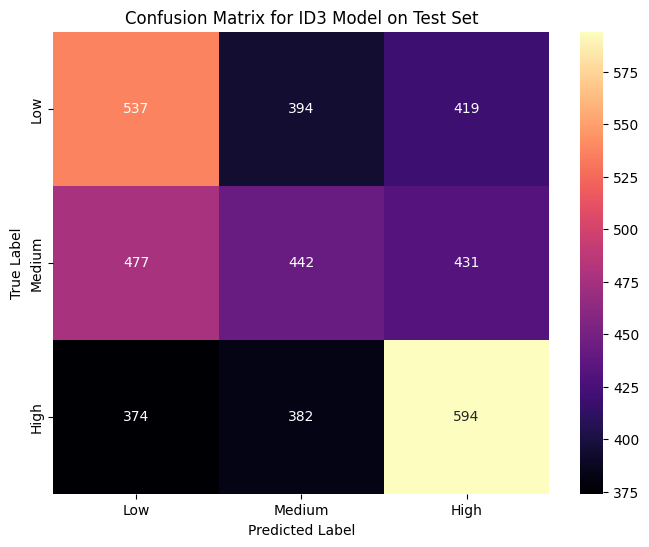


Test Set Accuracy: 0.3884

Metrics by Class:
Class '0' (Low=0, Medium=1, High=2):
  Precision: 0.3869
  Recall: 0.3978
  F1-Score: 0.3923
Class '1' (Low=0, Medium=1, High=2):
  Precision: 0.3629
  Recall: 0.3274
  F1-Score: 0.3442
Class '2' (Low=0, Medium=1, High=2):
  Precision: 0.4114
  Recall: 0.4400
  F1-Score: 0.4252


In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict function for the decision tree
def predict(node, sample):
    """Predict the label for a sample by traversing the decision tree."""
    # Leaf node: return the label
    if node.label is not None:
        return node.label

    # Fail-safe: if the node was pruned and no feature exists
    if node.feature is None:
        # You can return a default class or raise an error
        return y_train.mode()[0]  # Fallback to most common label in training

    feature_value = sample[node.feature]
    
    # Threshold-based split (numerical feature)
    if node.threshold is not None:
        if feature_value <= node.threshold:
            key = "<= {:.2f}".format(node.threshold)
        else:
            key = "> {:.2f}".format(node.threshold)
    else:
        # Categorical feature
        key = feature_value

    # Traverse the tree
    if key in node.children:
        return predict(node.children[key], sample)
    else:
        # Fallback if unexpected category appears
        return y_train.mode()[0]


# Make predictions on the test set
y_pred = [predict(tree, X_test.iloc[i]) for i in range(len(X_test))]

# Check consistency of y_test and y_pred
print("y_test sample:", y_test.head().tolist())
print("y_pred sample:", y_pred[:5])
print("y_test unique values:", np.unique(y_test))
print("y_pred unique values:", np.unique(y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="magma", 
            xticklabels=["Low", "Medium", "High"], 
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix for ID3 Model on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Define class labels and compute metrics
labels = np.unique(y_test)  # e.g., [0, 1, 2]
accuracy, precision, recall, f1_score = compute_metrics(y_test, y_pred, labels)

# Print results
print(f"\nTest Set Accuracy: {accuracy:.4f}")
print("\nMetrics by Class:")
for label in labels:
    print(f"Class '{label}' (Low={0}, Medium={1}, High={2}):")
    print(f"  Precision: {precision[label]:.4f}")
    print(f"  Recall: {recall[label]:.4f}")
    print(f"  F1-Score: {f1_score[label]:.4f}")

### **📌 Comments About the Results**

Before oversampling, our model had a **higher accuracy**, but most of the predictions were biased toward the majority class ("Low").  

After analyzing the behavior of the model and doing some research, we decided to **intentionally lower accuracy** in favor of more balanced predictions across all classes.

>This is not a drawback — in **multi-class imbalanced datasets**, it’s more meaningful to focus on **F1-score** rather than accuracy, since it better reflects how well the model performs on all classes, especially the minority ones.

### **🔍 Analyzing Misclassified Examples**

We identify a few misclassified samples from the test set and analyze why they might have been difficult to classify.

In [19]:
# Find misclassified examples
misclassified = []
for i in range(len(y_test)):
    if y_pred[i] != y_test.iloc[i]:
        misclassified.append((i, X_test.iloc[i], y_pred[i], y_test.iloc[i]))
        if len(misclassified) >= 3:  # 3 examples are enough
            break

# Print misclassified examples
print("Misclassified Examples:")
for idx, (index, sample, pred, actual) in enumerate(misclassified):
    print(f"\nExample {idx+1} (Index {index}):")
    print(f"Features: {sample.to_dict()}")
    print(f"Predicted: {pred}, Actual: {actual}")

Misclassified Examples:

Example 1 (Index 0):
Features: {'Age': 32.0, 'Gender': 2.0, 'Education Level': 0.0, 'Income': 86635.0, 'Credit Score': 731.0, 'Loan Amount': 25328.0, 'Loan Purpose': 2.0, 'Employment Status': 1.0, 'Years at Current Job': 6.0, 'Payment History': 2.0, 'Debt-to-Income Ratio': 0.468654600773765, 'Assets Value': 199952.0, 'Number of Dependents': 0.0, 'Previous Defaults': 4.0, 'Marital Status Change': 0.0}
Predicted: 1, Actual: 0

Example 2 (Index 2):
Features: {'Age': 28.0, 'Gender': 2.0, 'Education Level': 1.0, 'Income': 81072.0, 'Credit Score': 741.0, 'Loan Amount': 36087.0, 'Loan Purpose': 2.0, 'Employment Status': 0.0, 'Years at Current Job': 3.0, 'Payment History': 0.0, 'Debt-to-Income Ratio': 0.2818347785903988, 'Assets Value': 159362.0, 'Number of Dependents': 0.0, 'Previous Defaults': 1.0, 'Marital Status Change': 2.0}
Predicted: 2, Actual: 0

Example 3 (Index 4):
Features: {'Age': 26.0, 'Gender': 2.0, 'Education Level': 2.0, 'Income': 88555.0, 'Credit Score

### **📝 Comments on Misclassified Examples**

- **Example 1**: Predicted **Medium** instead of **Low**. Despite strong financials, the **4 previous defaults** and **high debt-to-income (0.47)** likely led the model to overestimate risk.

- **Example 2**: Predicted **High** instead of **Low**. Good credit and income, but **1 previous default** and possibly **marital status change** may have skewed the decision.

- **Example 3**: Predicted **Low** instead of **Medium**. Strong profile overall, but **2 previous defaults** might have justified a Medium label.

- **Overall**: Most errors involve borderline cases where the model struggles to balance **past defaults** against otherwise strong features.

### **⚖️ Comparing ID3 Model Variations**

We evaluated **six ID3 model variants** to observe the effects of **tree complexity** and **depth limitation** on performance:

1. **ID3 (No Depth Limit)**  
2. **ID3 with Limited Depth** – `max_depth=4`  
3. **ID3 with Limited Depth** – `max_depth=5`  
4. **ID3 with Limited Depth** – `max_depth=6`  
5. **ID3 with Limited Depth** – `max_depth=7`  
6. **ID3 with Limited Depth** – `max_depth=8`  

This comparison helps us understand how increasing depth impacts model accuracy, potential overfitting, and generalization.

In [20]:
import time
import numpy as np

# Generalized training and evaluation function
def train_and_evaluate(name, X_train, y_train, features, class_weights, X_test, y_test, labels, max_depth=None):
    # Training start
    start_train = time.time()
    tree = id3(X_train, y_train, features, class_weights, max_depth=max_depth)
    end_train = time.time()

    # Prediction start
    start_pred = time.time()
    y_pred = [predict(tree, X_test.iloc[i]) for i in range(len(X_test))]
    end_pred = time.time()

    # Compute metrics
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred, labels)

    # Print results
    print(f"{name}:")
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision: {[f'{prec[label]:.4f}' for label in labels]}")
    print(f"  - Recall: {[f'{rec[label]:.4f}' for label in labels]}")
    print(f"  - F1-Score: {[f'{f1[label]:.4f}' for label in labels]}")
    print(f"  - Training Time: {end_train - start_train:.2f} seconds")
    print(f"  - Prediction Time: {end_pred - start_pred:.2f} seconds\n")

    return acc, tree

labels = np.unique(y_test)

print("📊 Model Variations Comparison:\n")
# 1. No depth limit
acc1, tree1 = train_and_evaluate("1. ID3 (No Depth Limit)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels)

# 2. Limited depth = 4
acc2, tree2 = train_and_evaluate("2. ID3 (Max Depth = 4)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels, max_depth=4)

# 3. Limited depth = 5
acc3, tree3 = train_and_evaluate("3. ID3 (Max Depth = 5)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels, max_depth=5)

# 4. Limited depth = 6
acc4, tree4 = train_and_evaluate("4. ID3 (Max Depth = 6)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels, max_depth=6)

# 5. Limited depth = 7
acc5, tree5 = train_and_evaluate("5. ID3 (Max Depth = 7)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels, max_depth=7)

# 6. Limited depth = 8
acc6, tree6 = train_and_evaluate("6. ID3 (Max Depth = 8)", X_train, y_train, features, class_weights_dict, X_test, y_test, labels, max_depth=8)

📊 Model Variations Comparison:

1. ID3 (No Depth Limit):
  - Accuracy: 0.3881
  - Precision: ['0.3879', '0.3641', '0.4091']
  - Recall: ['0.4022', '0.3304', '0.4319']
  - F1-Score: ['0.3949', '0.3464', '0.4202']
  - Training Time: 385.65 seconds
  - Prediction Time: 0.19 seconds

2. ID3 (Max Depth = 4):
  - Accuracy: 0.3726
  - Precision: ['0.3726', '0.3460', '0.4041']
  - Recall: ['0.5933', '0.2637', '0.2607']
  - F1-Score: ['0.4577', '0.2993', '0.3170']
  - Training Time: 316.37 seconds
  - Prediction Time: 0.15 seconds

3. ID3 (Max Depth = 5):
  - Accuracy: 0.3723
  - Precision: ['0.3712', '0.3492', '0.4032']
  - Recall: ['0.5859', '0.2719', '0.2593']
  - F1-Score: ['0.4545', '0.3057', '0.3156']
  - Training Time: 344.17 seconds
  - Prediction Time: 0.11 seconds

4. ID3 (Max Depth = 6):
  - Accuracy: 0.3783
  - Precision: ['0.3904', '0.3480', '0.3892']
  - Recall: ['0.4378', '0.2874', '0.4096']
  - F1-Score: ['0.4127', '0.3148', '0.3991']
  - Training Time: 353.91 seconds
  - Predic

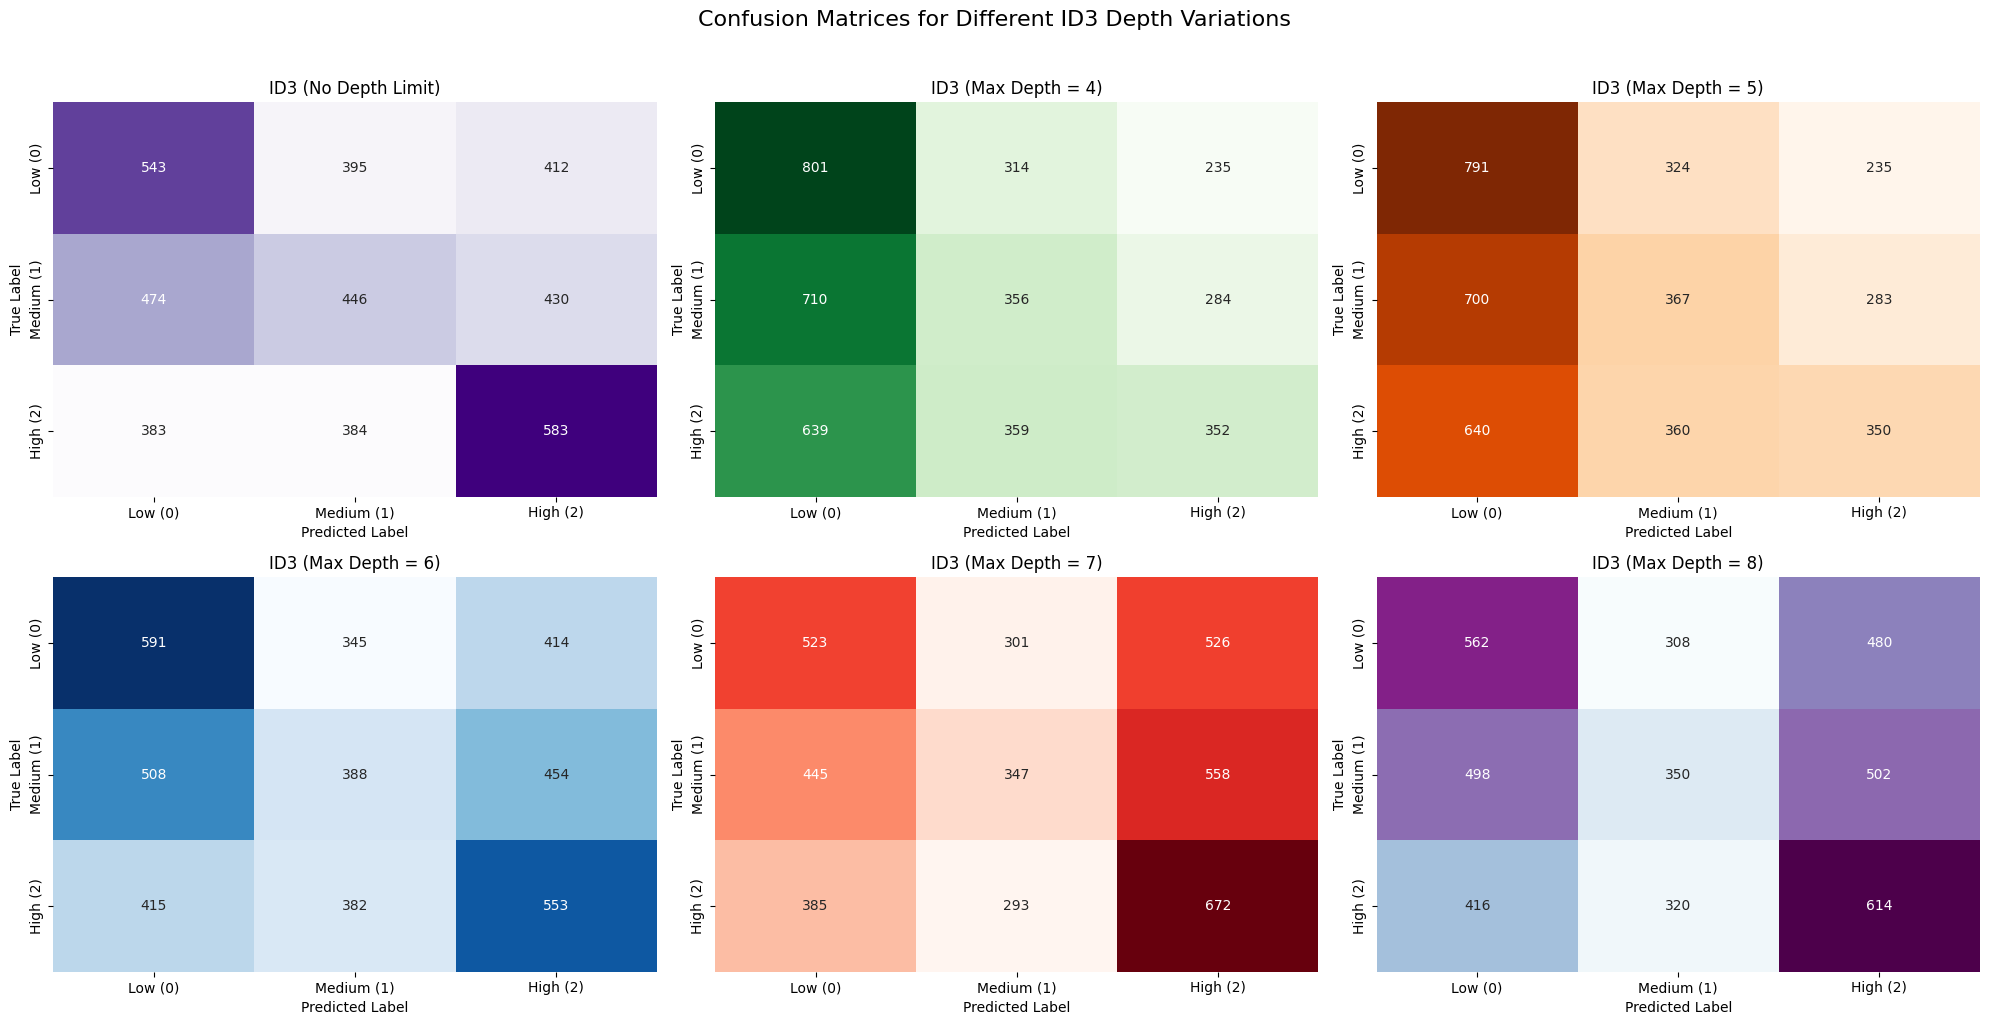

In [21]:
# Save predictions for all models
y_preds = [
    [predict(tree1, X_test.iloc[i]) for i in range(len(X_test))],
    [predict(tree2, X_test.iloc[i]) for i in range(len(X_test))],
    [predict(tree3, X_test.iloc[i]) for i in range(len(X_test))],
    [predict(tree4, X_test.iloc[i]) for i in range(len(X_test))],
    [predict(tree5, X_test.iloc[i]) for i in range(len(X_test))],
    [predict(tree6, X_test.iloc[i]) for i in range(len(X_test))]
]

# Labels
labels = [0, 1, 2]
label_names = ["Low (0)", "Medium (1)", "High (2)"]

# Compute confusion matrices
cms = [confusion_matrix(y_test, y_pred, labels=labels) for y_pred in y_preds]

# Titles and color palettes
titles = [
    "ID3 (No Depth Limit)", 
    "ID3 (Max Depth = 4)", 
    "ID3 (Max Depth = 5)", 
    "ID3 (Max Depth = 6)", 
    "ID3 (Max Depth = 7)", 
    "ID3 (Max Depth = 8)"
]
palettes = ['Purples', 'Greens', 'Oranges', 'Blues', 'Reds', 'BuPu']

# Plotting: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, cm, title, cmap in zip(axes.flatten(), cms, titles, palettes):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
                xticklabels=label_names, yticklabels=label_names, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.suptitle("Confusion Matrices for Different ID3 Depth Variations", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **📊 Comparative Evaluation of ID3 Trees with Different Depths**

We trained **six ID3 models** with varying maximum depths to analyze how tree complexity impacts classification performance.  
Each confusion matrix above shows how well the model predicted each class on the test set.

- **Shallower trees (Depth 4–5)** tend to oversimplify the problem, sometimes ignoring one or more classes.
- **Deeper trees (Depth 6–8)** capture more patterns and improve **F1-Scores**, especially for the **High Risk** class.
- **Unlimited depth** produces more balanced predictions across all classes but at the cost of **very long training time** and **higher risk of overfitting**.

> 🧠 In multi-class imbalanced datasets, **accuracy can be misleading**.  
> Instead, we focus on **F1-Score**, especially for underrepresented classes like *Medium* and *High* risk.

✅ Based on a careful balance between:
- Overall **F1 performance**
- **Training time**
- And **prediction stability**

➡️ We selected the **model with `max_depth=6`** for **post-pruning**.  
This tree provides strong recall for minority classes while avoiding full overfitting.

### **⚖️ Trade-off Summary**

- **Deeper trees** (like the full model) better capture minority class variation but take much longer to train.
- **Shallow trees** (max_depth=4 or 5) reduce overfitting and training time but harm recall for underrepresented classes.
- **None of the trees generalize perfectly** — there's always a trade-off between precision, recall, and speed.

> As a form of **pre-pruning**, we removed low-information features such as *City*, *State*, *Country* and *Marital Status Change*.

### **🌳 Rules of the Best Decision Tree**

The best-performing model is the ID3 with a subset of features (excluding 'Marital Status Change'), achieving a test accuracy of 0.4893. Below are the root-to-leaf paths of this tree, representing the decision rules in left-to-right order.

In [22]:
def print_tree_rules(node, path=""):
    """
    Recursively print all root-to-leaf decision rules from the decision tree.
    Each path represents a rule ending in a predicted class.
    """
    if node.label is not None:
        print(f"{path} -> Predict: {node.label}")
        return
    for condition, child in node.children.items():
        new_path = f"{path} -> [{node.feature} {condition}]" if path else f"[{node.feature} {condition}]"
        print_tree_rules(child, new_path)

# Print the rules of the final trained tree (e.g., after oversampling + class weights)
print("🌳 Decision Tree Rules (Root-to-Leaf Paths) for the Final Model:")

print_tree_rules(tree4)

🌳 Decision Tree Rules (Root-to-Leaf Paths) for the Final Model:
[Years at Current Job <= -0.00] -> [Income <= 61649.15] -> [Debt-to-Income Ratio <= 0.42] -> [Assets Value <= 173783.91] -> [Marital Status Change <= 0.00] -> [Credit Score <= 642.12] -> Predict: 1
[Years at Current Job <= -0.00] -> [Income <= 61649.15] -> [Debt-to-Income Ratio <= 0.42] -> [Assets Value <= 173783.91] -> [Marital Status Change <= 0.00] -> [Credit Score > 642.12] -> Predict: 2
[Years at Current Job <= -0.00] -> [Income <= 61649.15] -> [Debt-to-Income Ratio <= 0.42] -> [Assets Value <= 173783.91] -> [Marital Status Change > 0.00] -> Predict: 2
[Years at Current Job <= -0.00] -> [Income <= 61649.15] -> [Debt-to-Income Ratio <= 0.42] -> [Assets Value > 173783.91] -> [Loan Amount <= 17653.52] -> Predict: 2
[Years at Current Job <= -0.00] -> [Income <= 61649.15] -> [Debt-to-Income Ratio <= 0.42] -> [Assets Value > 173783.91] -> [Loan Amount > 17653.52] -> [Credit Score <= 608.94] -> Predict: 1
[Years at Current J

In [25]:
print("tree4 root feature:", getattr(tree4, "feature", None))

sample = X_test.iloc[0]
print("Sample:", sample.to_dict())
print("True label:", y_test.iloc[0])
print("Predicted:", predict(tree4, sample))

predictions = [predict(tree4, X_test.iloc[i]) for i in range(len(X_test))]
print("Unique predictions:", set(predictions))

print("Predicted dtype:", type(predictions[0]))
print("Actual dtype:", type(y_test.iloc[0]))

tree4 root feature: Years at Current Job
Sample: {'Age': 32.0, 'Gender': 2.0, 'Education Level': 0.0, 'Income': 86635.0, 'Credit Score': 731.0, 'Loan Amount': 25328.0, 'Loan Purpose': 2.0, 'Employment Status': 1.0, 'Years at Current Job': 6.0, 'Payment History': 2.0, 'Debt-to-Income Ratio': 0.468654600773765, 'Assets Value': 199952.0, 'Number of Dependents': 0.0, 'Previous Defaults': 4.0, 'Marital Status Change': 0.0}
True label: 0
Predicted: 0
Unique predictions: {np.int64(0), np.int64(1), np.int64(2)}
Predicted dtype: <class 'numpy.int64'>
Actual dtype: <class 'numpy.int64'>


# **Part 2: Pruning ✂️**

### **🌿 Post-Pruning Strategy (Max Depth = 6)**

We applied post-pruning to the **ID3 tree with max depth = 6**, which previously achieved a solid F1-Score for the **"High Risk"** class.

Although deeper trees capture more complexity, they often lead to overfitting.  
To improve generalization and reduce complexity, we pruned redundant branches from the tree following this process:

1. **Find all twigs** (internal nodes whose children are all leaves).
2. **Estimate information gain** for each twig.
3. **Convert the twig to a leaf** using the majority class.
4. Evaluate the model on the **validation set**.
5. Keep the change **only if both accuracy and average F1-Score do not drop**.
6. Repeat until no more beneficial pruning is possible.

This approach helped us **simplify the model**, reduce overfitting, and preserve performance across all classes.

In [26]:
import copy

# Get majority class (random tie-breaker)
def get_majority_class(y):
    mode = y.mode()
    return mode.sample(1).values[0] if len(mode) > 1 else mode.values[0]

# Find twig nodes (internal nodes whose children are all leaves)
def find_twigs(node):
    twigs = []
    def dfs(n):
        if n.label is not None:
            return
        if all(child.label is not None for child in n.children.values()):
            twigs.append(n)
        else:
            for child in n.children.values():
                dfs(child)
    dfs(node)
    return twigs

# Estimate Information Gain of a twig node
def estimate_information_gain(node, X_val, y_val, class_weights):
    if node.feature is None:
        return float('inf')
    values = X_val[node.feature]
    return information_gain(values, y_val, class_weights)[0]

# Pruning Algorithm
def prune_tree(tree, X_val, y_val, class_weights, labels):
    best_tree = copy.deepcopy(tree)
    default_class = get_majority_class(y_val)

    # Initial evaluation
    y_pred_val = [predict(tree, X_val.iloc[i]) for i in range(len(X_val))]
    last_acc, _, _, last_f1 = compute_metrics(y_val, y_pred_val, labels)
    last_avg_f1 = np.mean(list(last_f1.values()))

    print("Initial Validation:")
    print(f"  Accuracy: {last_acc:.4f}")
    print(f"  Avg F1-Score: {last_avg_f1:.4f}")

    while True:
        twigs = find_twigs(tree)
        if not twigs:
            print("No more twigs to prune.")
            break

        # Step 2: Select twig with lowest information gain
        twig_to_prune = min(twigs, key=lambda t: estimate_information_gain(t, X_val, y_val, class_weights))

        # Step 3–4: Prune and relabel
        original_children = twig_to_prune.children
        original_feature = twig_to_prune.feature
        twig_to_prune.children = {}
        twig_to_prune.feature = None

        # Step 4: Assign label based on majority class of affected samples
        indices = []
        for i in range(len(X_val)):
            if predict(tree, X_val.iloc[i]) == predict(twig_to_prune, X_val.iloc[i]):
                indices.append(i)

        if indices:
            y_subset = y_val.iloc[indices]
            twig_to_prune.label = get_majority_class(y_subset)
        else:
            twig_to_prune.label = get_majority_class(y_val)

        # Step 5: Evaluate
        y_pred_val = [predict(tree, X_val.iloc[i]) for i in range(len(X_val))]
        acc, _, _, f1 = compute_metrics(y_val, y_pred_val, labels)
        avg_f1 = np.mean(list(f1.values()))

        print(f"\nPruned '{original_feature}' → Accuracy: {acc:.4f}, Avg F1: {avg_f1:.4f}")

        # Step 6: Keep or revert
        if acc >= last_acc and avg_f1 >= last_avg_f1:
            print("→ Kept pruning.")
            last_acc = acc
            last_avg_f1 = avg_f1
            best_tree = copy.deepcopy(tree)
        else:
            # Revert changes
            twig_to_prune.children = original_children
            twig_to_prune.feature = original_feature
            twig_to_prune.label = None
            print("→ Reverted. Stopping pruning.")
            break

    return best_tree

In [29]:
# Apply pruning to the tree with max_depth = 6 (tree4)
pruned_tree = prune_tree(tree4, X_val, y_val, class_weights_dict, labels)

Initial Validation:
  Accuracy: 0.3657
  Avg F1-Score: 0.3632

Pruned 'Previous Defaults' → Accuracy: 0.3642, Avg F1: 0.3596
→ Reverted. Stopping pruning.


In [30]:
# Function to compare two trees
def compare_models(pre_tree, post_tree, X_train, y_train, X_val, y_val, X_test, y_test, labels):
    def evaluate(tree, X, y):
        y_pred = [predict(tree, X.iloc[i]) for i in range(len(X))]
        return compute_metrics(y, y_pred, labels)

    print("🔍 Pre-Pruning Performance:\n")
    train_pre = evaluate(pre_tree, X_train, y_train)
    val_pre = evaluate(pre_tree, X_val, y_val)
    test_pre = evaluate(pre_tree, X_test, y_test)

    print("Train Set:")
    print_metrics(train_pre, labels)
    print("\nValidation Set:")
    print_metrics(val_pre, labels)
    print("\nTest Set:")
    print_metrics(test_pre, labels)

    print("\n🌿 Post-Pruning Performance:\n")
    train_post = evaluate(post_tree, X_train, y_train)
    val_post = evaluate(post_tree, X_val, y_val)
    test_post = evaluate(post_tree, X_test, y_test)

    print("Train Set:")
    print_metrics(train_post, labels)
    print("\nValidation Set:")
    print_metrics(val_post, labels)
    print("\nTest Set:")
    print_metrics(test_post, labels)

# Helper to print nicely
def print_metrics(results, labels):
    acc, prec, rec, f1 = results
    print(f"  Accuracy: {acc:.4f}")
    for label in labels:
        name = {0: "Low", 1: "Medium", 2: "High"}[label]
        print(f"  Class {name}: Precision={prec[label]:.4f}, Recall={rec[label]:.4f}, F1-Score={f1[label]:.4f}")


# Run comparison
compare_models(tree4, pruned_tree, X_train, y_train, X_val, y_val, X_test, y_test, labels)

🔍 Pre-Pruning Performance:

Train Set:
  Accuracy: 0.3866
  Class Low: Precision=0.3915, Recall=0.4325, F1-Score=0.4110
  Class Medium: Precision=0.3621, Recall=0.2994, F1-Score=0.3277
  Class High: Precision=0.4005, Recall=0.4279, F1-Score=0.4138

Validation Set:
  Accuracy: 0.3657
  Class Low: Precision=0.3762, Recall=0.4222, F1-Score=0.3979
  Class Medium: Precision=0.3375, Recall=0.2807, F1-Score=0.3065
  Class High: Precision=0.3768, Recall=0.3941, F1-Score=0.3852

Test Set:
  Accuracy: 0.3783
  Class Low: Precision=0.3901, Recall=0.4378, F1-Score=0.4126
  Class Medium: Precision=0.3483, Recall=0.2874, F1-Score=0.3149
  Class High: Precision=0.3892, Recall=0.4096, F1-Score=0.3991

🌿 Post-Pruning Performance:

Train Set:
  Accuracy: 0.3866
  Class Low: Precision=0.3915, Recall=0.4325, F1-Score=0.4110
  Class Medium: Precision=0.3621, Recall=0.2994, F1-Score=0.3277
  Class High: Precision=0.4005, Recall=0.4279, F1-Score=0.4138

Validation Set:
  Accuracy: 0.3657
  Class Low: Precisi